# Librerias

In [1]:
# Tratamiento de datos
import numpy as np
import pandas as pd

# Graficas
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Manipulacion de fechas
from datetime import date, timedelta, datetime
from dateutil.relativedelta import relativedelta

# Modelado y Forecasting
from lightgbm import LGBMRegressor
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import backtesting_forecaster
from sklearn.metrics import mean_absolute_error

# Descarga de archivos
import io
import urllib.request

c:\Users\vanchondo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\compat\pandas.py:61: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


# Funciones

In [2]:
# Funcion para mostrar grafico
# - dataFrame debe de ser un array de tuplas, donde el primer elemento es el dataFrame y 
# y el segundo es la etiqueta de se dataFrame
# - title es el titulo del grafico
def showPlot(dataFrames, title, yLabel='', xLabel=''):
  fig, ax = plt.subplots(figsize=(20,8))
  for frame in dataFrames:
    plt.plot(frame[0].index, frame[0], label=frame[1])

  ax.set_title(title)
  ax.set_ylabel(yLabel)
  ax.set_xlabel(xLabel)
  ax.legend()
  plt.show()

In [3]:
def getYesterdayEpoch():
  d = date.today() - timedelta(days=1)
  return str(datetime(d.year, d.month, d.day).timestamp()).replace('.0', '')

In [4]:
def downloadFile(url):
  with urllib.request.urlopen(url) as f:
      response = f.read().decode('utf-8')
  datos = pd.read_csv(io.StringIO(response))
  datos = datos.set_index("Date")
  return datos

In [6]:
def getLimitDates(datos, testDaysCount, trainDaysCount):
  startTestDate = datetime.now() - relativedelta(days = testDaysCount)
  
  trainStartDate = (startTestDate - relativedelta(days = trainDaysCount)).strftime('%Y-%m-%d')
  trainEndDate = (startTestDate - relativedelta(days = 1)).strftime('%Y-%m-%d')

  testStartDate = startTestDate.strftime('%Y-%m-%d')
  testEndDate = datos.index.max()

  return (
      trainStartDate,
      trainEndDate,
      testStartDate,
      testEndDate
  )

# Obtencion de los datos

In [18]:
# url para decargar los registros de Yahoo Finance, la fecha inicial es 2014-09-17 y la fecha final es el dia de hoy menos un dia (ayer)
btc_url = 'https://query1.finance.yahoo.com/v7/finance/download/BTC-USD?period1=1410825600&period2=' + getYesterdayEpoch() + '&interval=1d&events=history&includeAdjustedClose=true'

datos = downloadFile(btc_url)
datos.info()
display(datos)
print(f"Fecha inicio datos: {datos.index.min()}")
print(f"Fecha fin datos: {datos.index.max()}")

<class 'pandas.core.frame.DataFrame'>
Index: 2928 entries, 2014-09-17 to 2022-09-22
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2928 non-null   float64
 1   High       2928 non-null   float64
 2   Low        2928 non-null   float64
 3   Close      2928 non-null   float64
 4   Adj Close  2928 non-null   float64
 5   Volume     2928 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 160.1+ KB


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100
...,...,...,...,...,...,...
2022-09-18,20127.234375,20127.234375,19387.492188,19419.505859,19419.505859,31254779144
2022-09-19,19418.572266,19639.480469,18390.318359,19544.128906,19544.128906,40177002624
2022-09-20,19545.591797,19602.457031,18813.455078,18890.789063,18890.789063,36791346508


Fecha inicio datos: 2014-09-17
Fecha fin datos: 2022-09-22


# Preparacion de los datos

In [19]:
column = 'High' # <--- Columna/valores a usar
datos['Date'] = pd.to_datetime(datos.index, format='%Y-%m-%d %H:%M:%S')
datos = datos.loc[:, ['Date', column]]
datos = datos.set_index('Date')
datos = datos.asfreq('D')
datos = datos.sort_index()
datos.head

<bound method NDFrame.head of                     High
Date                    
2014-09-17    468.174011
2014-09-18    456.859985
2014-09-19    427.834991
2014-09-20    423.295990
2014-09-21    412.425995
...                  ...
2022-09-18  20127.234375
2022-09-19  19639.480469
2022-09-20  19602.457031
2022-09-21  19674.630859
2022-09-22  19456.910156

[2928 rows x 1 columns]>

In [20]:
# Verificar datos faltantes
print(f'Numero de filas con valores faltantes: {datos.isnull().any(axis=1).mean()}')

Numero de filas con valores faltantes: 0.0


# Analisis de datos

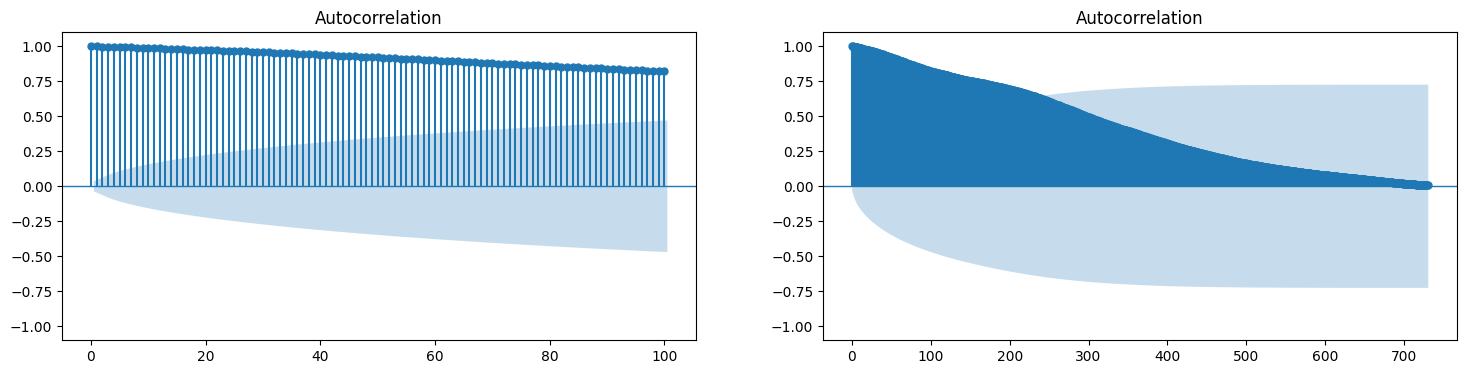

In [21]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 4))
axes = axes.flat
plot_acf(datos[column], ax=axes[0], linewidth = 1, lags=100)
axes[0].set_ylim(-1.1, 1.1)
plot_acf(datos[column], ax=axes[1], linewidth = 1, lags=730)
axes[1].set_ylim(-1.1, 1.1)
plt.show()

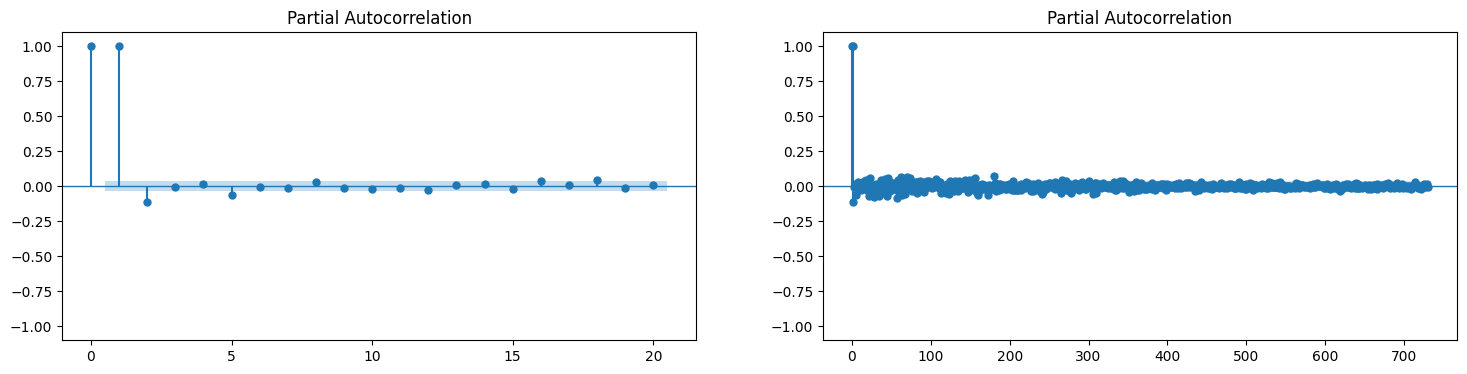

In [22]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 4))
axes = axes.flat
plot_pacf(datos[column], ax=axes[0], lags=20, method='ywm',  linewidth = 1)
axes[0].set_ylim(-1.1, 1.1)
plot_pacf(datos[column], ax=axes[1], lags=730, method='ywm',  linewidth = 1)
axes[1].set_ylim(-1.1, 1.1)
plt.show()

# Entrenamiento

## Seleccion de fechas para entrenamiento y pruebas

In [23]:
start_train, end_train, start_test, end_test = getLimitDates(datos, 400, 2500) # 120 dias para test y 1905 para train

print(f"Historial completo      : {datos.index.min()} --- {datos.index.max()}  (n={len(datos)})")
print(f"Fechas de entrenamiento : {datos.loc[start_train:end_train].index.min()} --- {datos.loc[start_train:end_train].index.max()}  (n={len(datos.loc[start_train:end_train])})")
print(f"Fechas de prueba        : {datos.loc[start_test:].index.min()} --- {datos.loc[start_test:].index.max()}  (n={len(datos.loc[start_test:])})")

Historial completo      : 2014-09-17 00:00:00 --- 2022-09-22 00:00:00  (n=2928)
Fechas de entrenamiento : 2014-10-15 00:00:00 --- 2021-08-18 00:00:00  (n=2500)
Fechas de prueba        : 2021-08-19 00:00:00 --- 2022-09-22 00:00:00  (n=400)


## Modelo autoregresivo recursivo

### Funciones

In [24]:
def train_backtesting_forecaster(lags, steps):
    # Forecasters backtest with different lags
    # ==============================================================================
    metrics = []
    predictions_list = []

    for lag in lags:
        
        # Create forecaster
        forecaster = ForecasterAutoreg(
                        regressor = LGBMRegressor(random_state=123),
                        lags      = lag
                        )
        
        # Backtest test data, 1 step
        metric, predictions = backtesting_forecaster(
                                    forecaster = forecaster,
                                    y          = datos.loc[start_train:, column],
                                    initial_train_size = len(datos.loc[start_train:end_train, column]),
                                    fixed_train_size   = True,
                                    steps      = steps,
                                    refit      = True,
                                    metric     = 'mean_absolute_error',
                                    verbose    = False
                                    )
        
        metrics.append(metric)
        predictions_list.append(predictions)  
        
    return (predictions_list, metrics)

In [25]:
def show_predictions(predictions_list, lags):
    tuples_array = [(datos.loc[end_train:, column], 'Datos de prueba')]
    for predictions, lag in zip(predictions_list, lags):
        tuples_array.append((predictions, f'Prediccion, {lag} lags'))

    showPlot(tuples_array, 'Datos de prueba vs Predicciones', 'Precio (USD)', 'Fechas')

In [26]:
def show_test_errors(metrics, lags):
    # Errores en pruebas
    model = 'LGBMRegressor'
    df_errors = pd.DataFrame({'model': model, 'lags': lags, 
                              'test_error': metrics})
    display(df_errors)

In [27]:
def train_and_show_predictions_and_errors(lags, steps):
    predictions_list, metrics = train_backtesting_forecaster(lags, steps)
    show_predictions(predictions_list, lags)
    show_test_errors(metrics, lags)

### 1 Dia

Forecaster will be fit 400 times. This can take substantial amounts of time. If not feasible, try with `refit = False`. 

Forecaster will be fit 400 times. This can take substantial amounts of time. If not feasible, try with `refit = False`. 

Forecaster will be fit 400 times. This can take substantial amounts of time. If not feasible, try with `refit = False`. 

Forecaster will be fit 400 times. This can take substantial amounts of time. If not feasible, try with `refit = False`. 

Forecaster will be fit 400 times. This can take substantial amounts of time. If not feasible, try with `refit = False`. 

Forecaster will be fit 400 times. This can take substantial amounts of time. If not feasible, try with `refit = False`. 



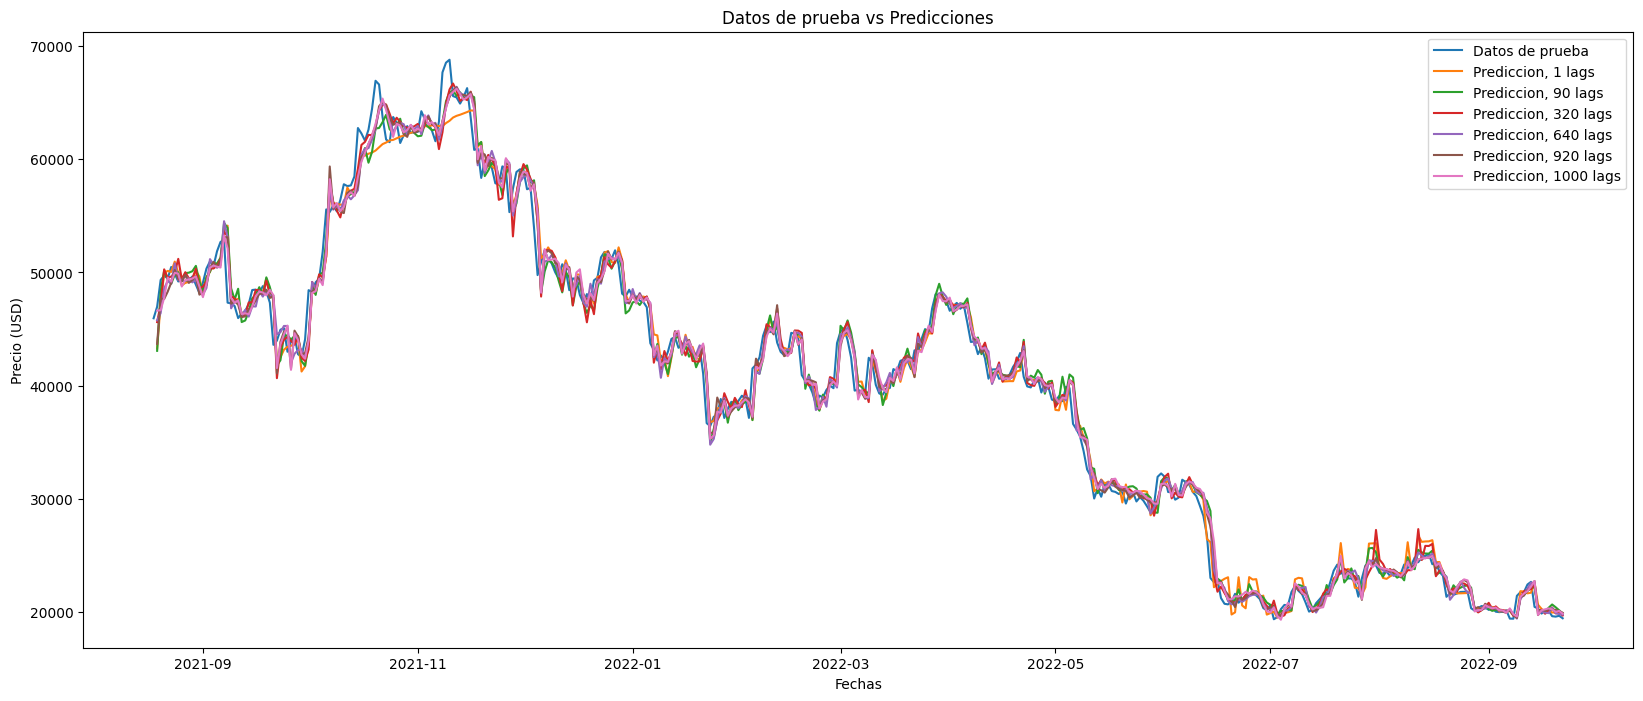

,model,lags,test_error
0,LGBMRegressor,1,1053.232790
1,LGBMRegressor,90,1052.225794
2,LGBMRegressor,320,1005.728255
3,LGBMRegressor,640,975.816317
4,LGBMRegressor,920,970.196945
5,LGBMRegressor,1000,987.495263


In [29]:
lags = [1, 90, 320, 640, 920, 1000]
# lags = [1, 30, 60, 120]
train_and_show_predictions_and_errors(lags, 1)

### 7 Dias

Forecaster will be fit 58 times. This can take substantial amounts of time. If not feasible, try with `refit = False`. 

Forecaster will be fit 58 times. This can take substantial amounts of time. If not feasible, try with `refit = False`. 

Forecaster will be fit 58 times. This can take substantial amounts of time. If not feasible, try with `refit = False`. 

Forecaster will be fit 58 times. This can take substantial amounts of time. If not feasible, try with `refit = False`. 

Forecaster will be fit 58 times. This can take substantial amounts of time. If not feasible, try with `refit = False`. 



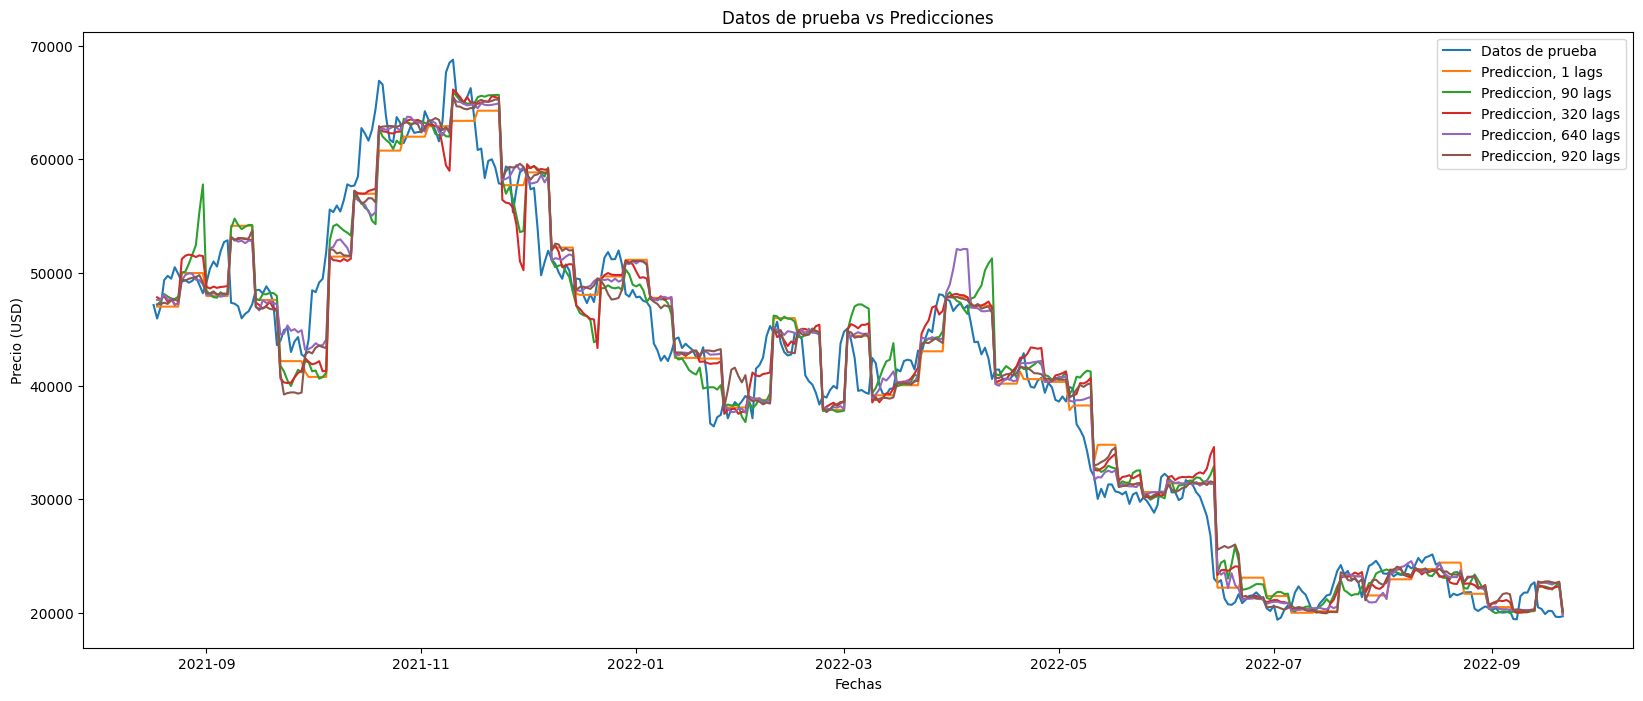

,model,lags,test_error
0,LGBMRegressor,1,2233.106967
1,LGBMRegressor,90,2332.169247
2,LGBMRegressor,320,2232.969309
3,LGBMRegressor,640,2055.832639
4,LGBMRegressor,920,2190.702507


In [21]:
# lags = [60, 90, 120, 160, 320]
train_and_show_predictions_and_errors(lags, 7)

### 1 Mes

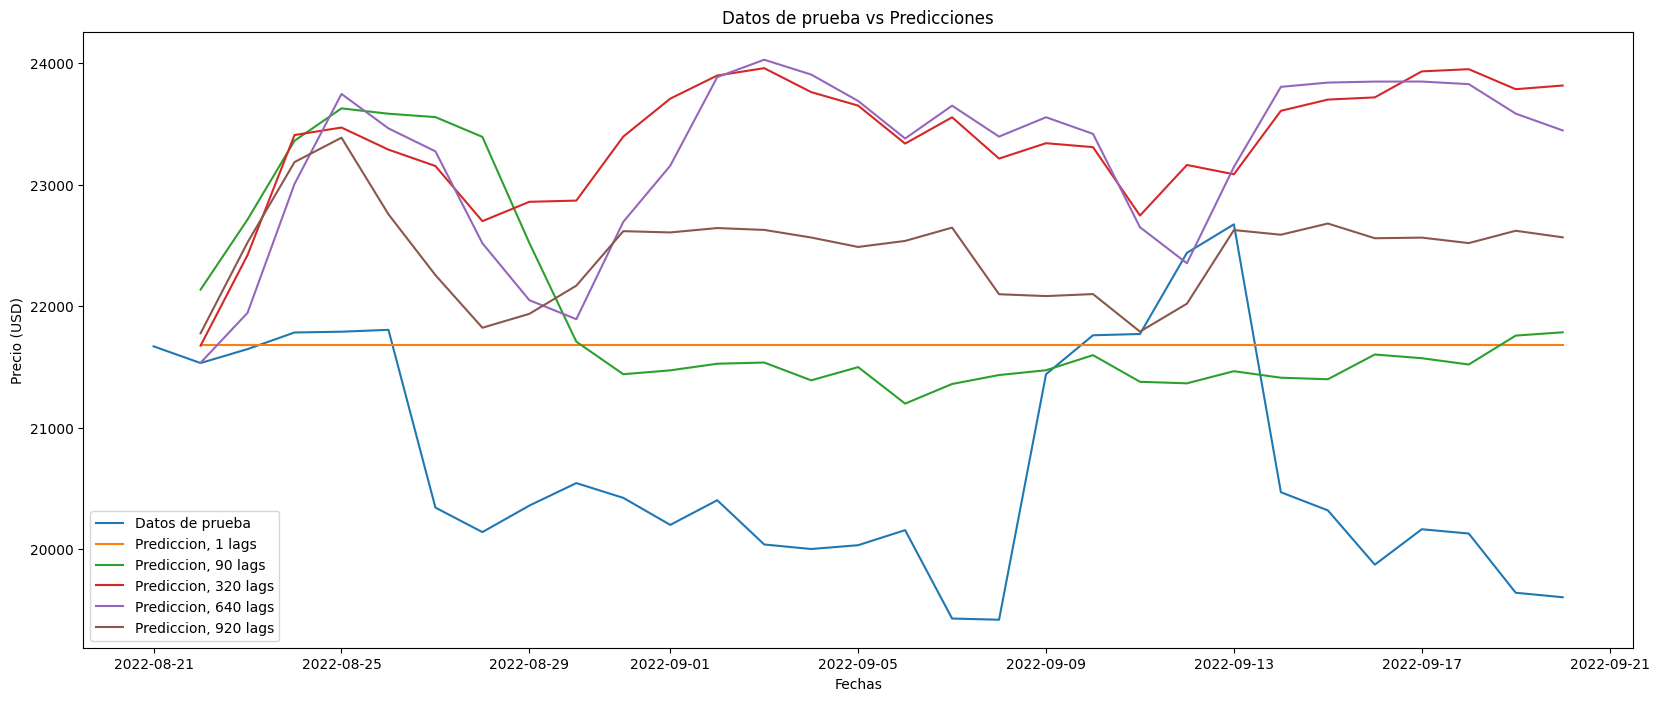

,model,lags,test_error
0,LGBMRegressor,1,1152.964642
1,LGBMRegressor,90,1438.612228
2,LGBMRegressor,320,2673.626102
3,LGBMRegressor,640,2547.859692
4,LGBMRegressor,920,1800.094538


In [29]:
# lags = [60, 90, 120, 160, 320]
train_and_show_predictions_and_errors(lags, 30)

### 1 Año

In [ ]:
# lags = [60, 90, 120, 160, 320]
train_and_show_predictions_and_errors(lags, 365)

Forecaster will be fit 365 times. This can take substantial amounts of time. If not feasible, try with `refit = False`. 



KeyboardInterrupt: 